In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import jax
import jax.numpy as jnp
from evosax import CMA_ES, SimAnneal

from envs.photon_langevin_env import BatchedPhotonLangevinReadoutEnv

In [73]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 4.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [74]:
env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [75]:
# Instantiate the search strategy
rng = jax.random.PRNGKey(0)
strategy = CMA_ES(popsize=batchsize, num_dims=env.num_actions, elite_ratio=0.5)
es_params = strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)
es_params

EvoParams(mu_eff=Array(17.62165241, dtype=float64), c_1=Array(0.00029451, dtype=float64), c_mu=Array(0.00454011, dtype=float64), c_sigma=Array(0.18935861, dtype=float64), d_sigma=Array(1.18935861, dtype=float64), c_c=Array(0.04936556, dtype=float64), chi_n=Array(8.97228754, dtype=float64, weak_type=True), c_m=1.0, sigma_init=1.0, init_min=-1, init_max=1, clip_min=-2.3255813953488373, clip_max=2.3255813953488373)

In [76]:
# Simulated Annealing

sim_anneal = SimAnneal(popsize=batchsize, num_dims=env.num_actions)
sim_params = sim_anneal.default_params
sim_params = sim_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)

In [77]:
def custom_rollout(batch_actions):
    res_drive = env.a0 * batch_actions.astype(jnp.float64)
    normalizing_factor = jnp.clip(
        env.mu * env.a0 / jnp.absolute(res_drive),
        0.0,
        1.0,
    )
    res_drive *= normalizing_factor
    res_drive = env.batched_smoother(res_drive)

    batch_res = env.batched_results(res_drive)
    reward, _ = env.batched_reward_and_state(
        batch_res.astype(env.float_dtype), res_drive
    )

    fitness = -reward # Since we are dealing with minimisation

    return fitness.astype(jnp.float32)

In [82]:
import time

state = sim_anneal.initialize(rng, sim_params)

start = time.time()
fitness_list = []

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(int(1e4)):
    rng, rng_gen, rng_eval = jax.random.split(rng, 3)
    x, state = sim_anneal.ask(rng_gen, state, sim_params)
    fitness = custom_rollout(x)
    state = sim_anneal.tell(x, fitness, state, sim_params)
    fitness_list.append(state.best_fitness)

    if (t + 1) % 100 == 0:
        # print("CMA-ES - # Gen: {}|Fitness: {:.5f}|Params: {}".format(
        #     t+1, state.best_fitness, state.best_member))
        print("CMA-ES - # Gen: {}|Fitness: {:.5f}".format(
            t+1, state.best_fitness))
        print(f"Time: {time.time() - start}")

CMA-ES - # Gen: 100|Fitness: -6.78943
Time: 2.2613701820373535
CMA-ES - # Gen: 200|Fitness: -17.70898
Time: 3.9183919429779053
CMA-ES - # Gen: 300|Fitness: -19.32902
Time: 5.421142101287842
CMA-ES - # Gen: 400|Fitness: -21.51026
Time: 6.953310012817383
CMA-ES - # Gen: 500|Fitness: -23.37134
Time: 8.7587308883667
CMA-ES - # Gen: 600|Fitness: -23.57042
Time: 10.216202974319458
CMA-ES - # Gen: 700|Fitness: -23.67908
Time: 11.939007997512817
CMA-ES - # Gen: 800|Fitness: -23.70400
Time: 13.505567073822021
CMA-ES - # Gen: 900|Fitness: -23.70463
Time: 15.070171117782593
CMA-ES - # Gen: 1000|Fitness: -23.70666
Time: 16.583476066589355
CMA-ES - # Gen: 1100|Fitness: -23.70672
Time: 17.94868803024292
CMA-ES - # Gen: 1200|Fitness: -23.71151
Time: 19.32275700569153
CMA-ES - # Gen: 1300|Fitness: -23.71237
Time: 20.898744106292725
CMA-ES - # Gen: 1400|Fitness: -23.71260
Time: 22.36349320411682
CMA-ES - # Gen: 1500|Fitness: -23.71314
Time: 23.70378017425537
CMA-ES - # Gen: 1600|Fitness: -23.71419
Time

KeyboardInterrupt: 

[ 2.3255814   2.28532237  2.3255814   2.3255814   2.3255814   2.3255814
  2.3255814   2.3223968   2.28330511  2.29432786  2.20102703  1.98032303
  1.96207035  1.76863617  1.6382154   1.81111864  1.54516943  2.0357042
  1.36991323  1.90170661  1.37329689  1.79864586  1.40016886  1.71184663
  1.69558883  1.50606664  1.60562043  1.40521896  1.29582332  1.40496397
  1.33340141  1.25066264  1.40924912  0.94530777  1.26174624  0.66917169
  0.73135437  0.21397683 -0.15634723 -0.54096479 -1.13298016 -1.29949172
 -1.82974437 -1.94654503 -1.98375764 -2.18764872 -2.18283336 -2.32012029
 -2.295214   -2.29076469 -2.31638756 -2.21413718 -2.30347929 -2.2189203
 -2.3255814  -2.26542173 -2.28038491 -2.23601768 -2.18258477 -2.20348373
 -2.22868992 -2.30502567 -2.3148373  -2.20219041 -1.93260764 -1.60902778
 -1.32661988 -0.77519563 -0.65342269  0.42983172  0.49824438  1.48227588
  1.5225594   2.04644038  2.16661317  2.3255814   2.31238946  2.2897202
  2.31113911  1.94337885  2.3255814 ]


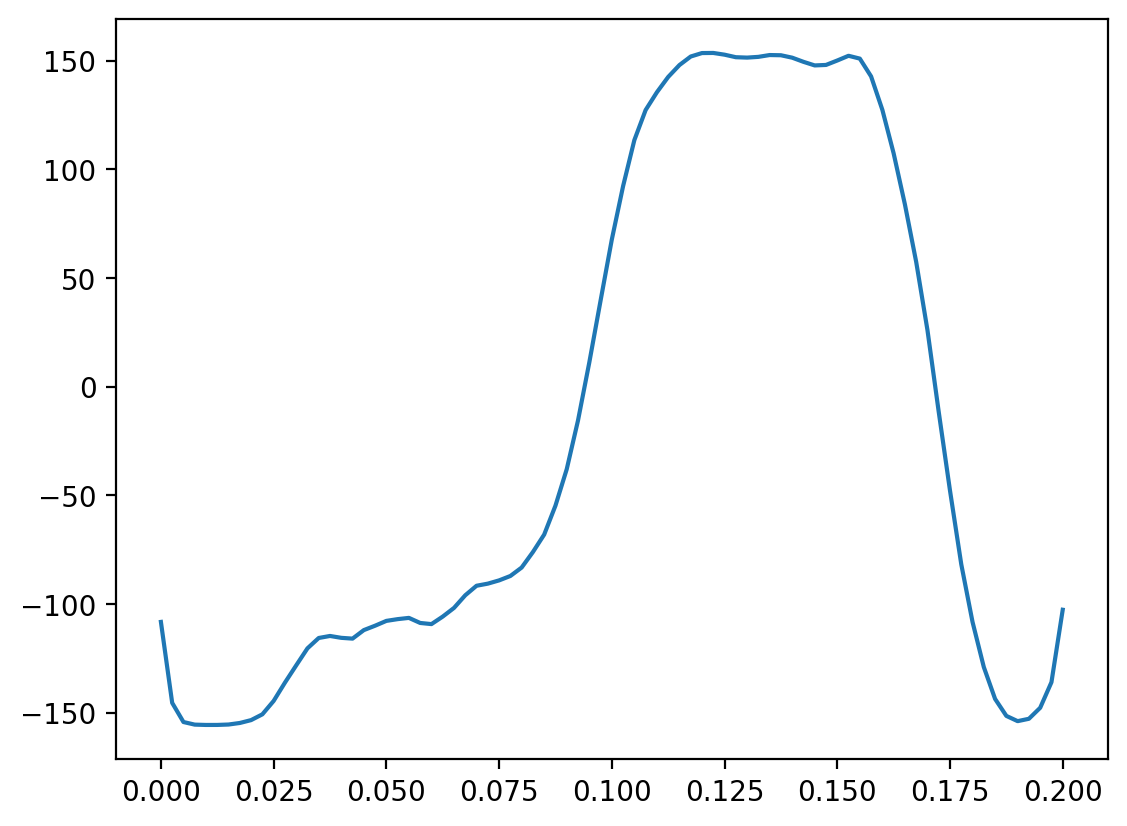

In [83]:
import matplotlib.pyplot as plt

action = state.best_member
action *= env.a0
action = -env.drive_smoother(action)

print(state.best_member)
plt.plot(env.ts_action, action)
plt.show()

In [84]:
batched_action = jnp.tile(action, (batchsize, 1))

batched_res = env.batched_results(batched_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    max_pf_times,
    smoothness_vals,
    b_pf,
    b_higher_photons,
) = env.batched_extract_values(batched_res, batched_action)

0.013605884596158207
359
0.4035295496259901
241


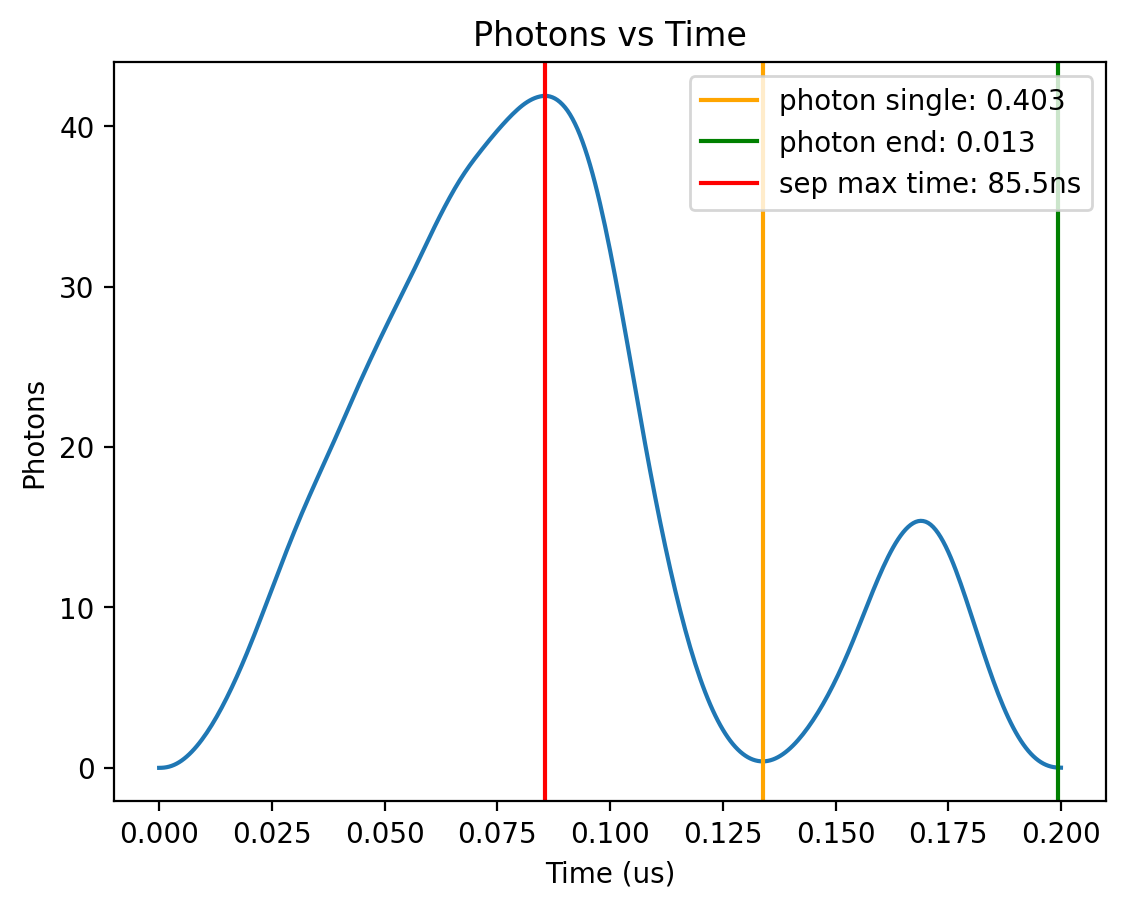

In [85]:
single_photon = b_higher_photons[0]

single_res = batched_res[0]
g_real, g_imag, e_real, e_imag = single_res.T
single_sep = jnp.sqrt((g_real - g_imag) ** 2 + (e_real - e_imag) ** 2)

ext = 50
ext_15 = 300
ext_2 = -1

min_photon = jnp.min(single_photon[ext:ext_2])
argmin = jnp.argmin(single_photon[ext:ext_2]) + ext

min_photon_2 = jnp.min(single_photon[ext:ext_15])
argmin_2 = jnp.argmin(single_photon[ext:ext_15]) + ext

argmax = jnp.argmax(single_sep)

print(min_photon)
print(argmin)

print(min_photon_2)
print(argmin_2)

plt.plot(env.ts_sim, single_photon)
plt.axvline(x=env.ts_sim[argmin_2], label=f'photon single: {int(1e3*min_photon_2)/1e3}', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'photon end: {int(1e3*min_photon)/1e3}', color='green')
plt.axvline(x=env.ts_sim[argmax], label=f'sep max time: {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.xlabel('Time (us)')
plt.ylabel('Photons')
plt.title('Photons vs Time')
plt.legend()
plt.show()

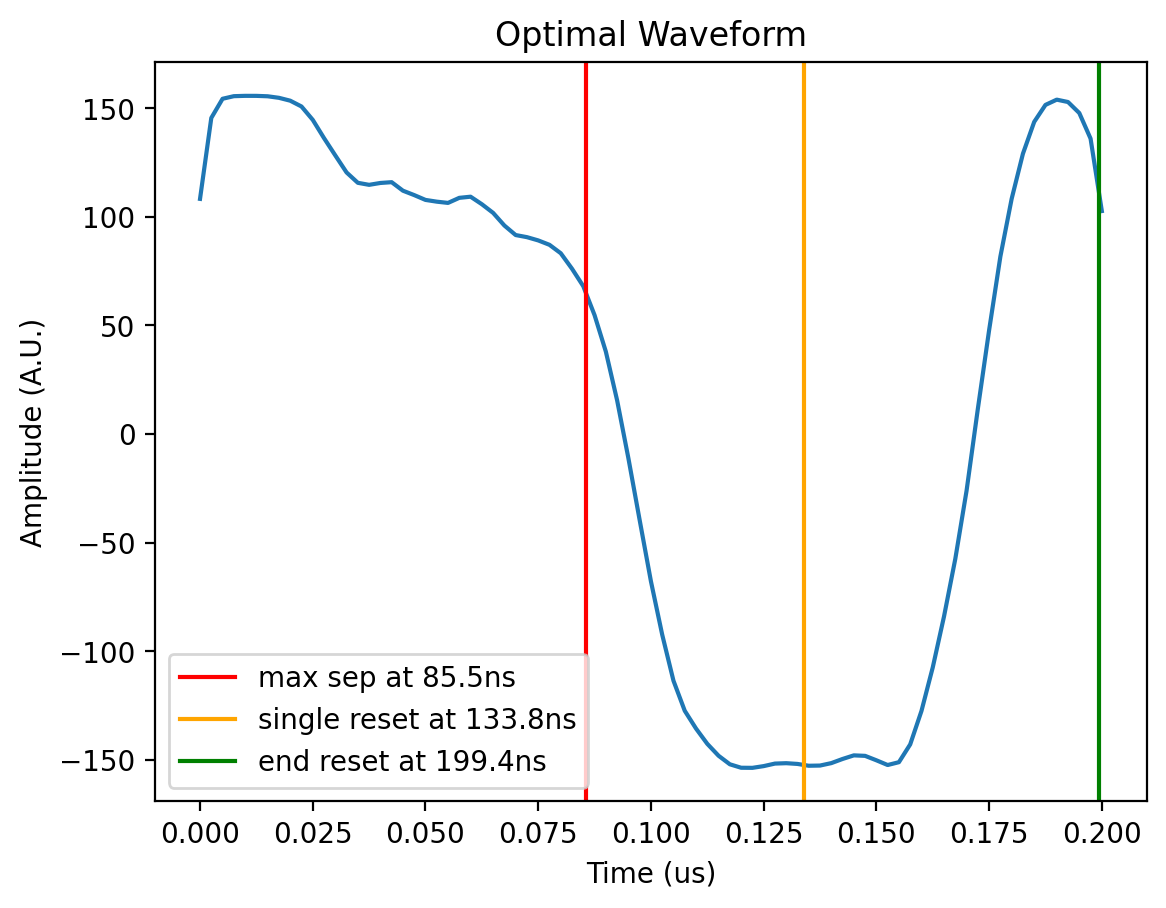

In [89]:
plt.plot(env.ts_action, -action)
plt.axvline(x=env.ts_sim[argmax], label=f'max sep at {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.axvline(x=env.ts_sim[argmin_2], label=f'single reset at {int(1e4*env.ts_sim[argmin_2])/1e1}ns', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'end reset at {int(1e4*env.ts_sim[argmin])/1e1}ns', color='green')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Optimal Waveform')
plt.legend()
plt.show()

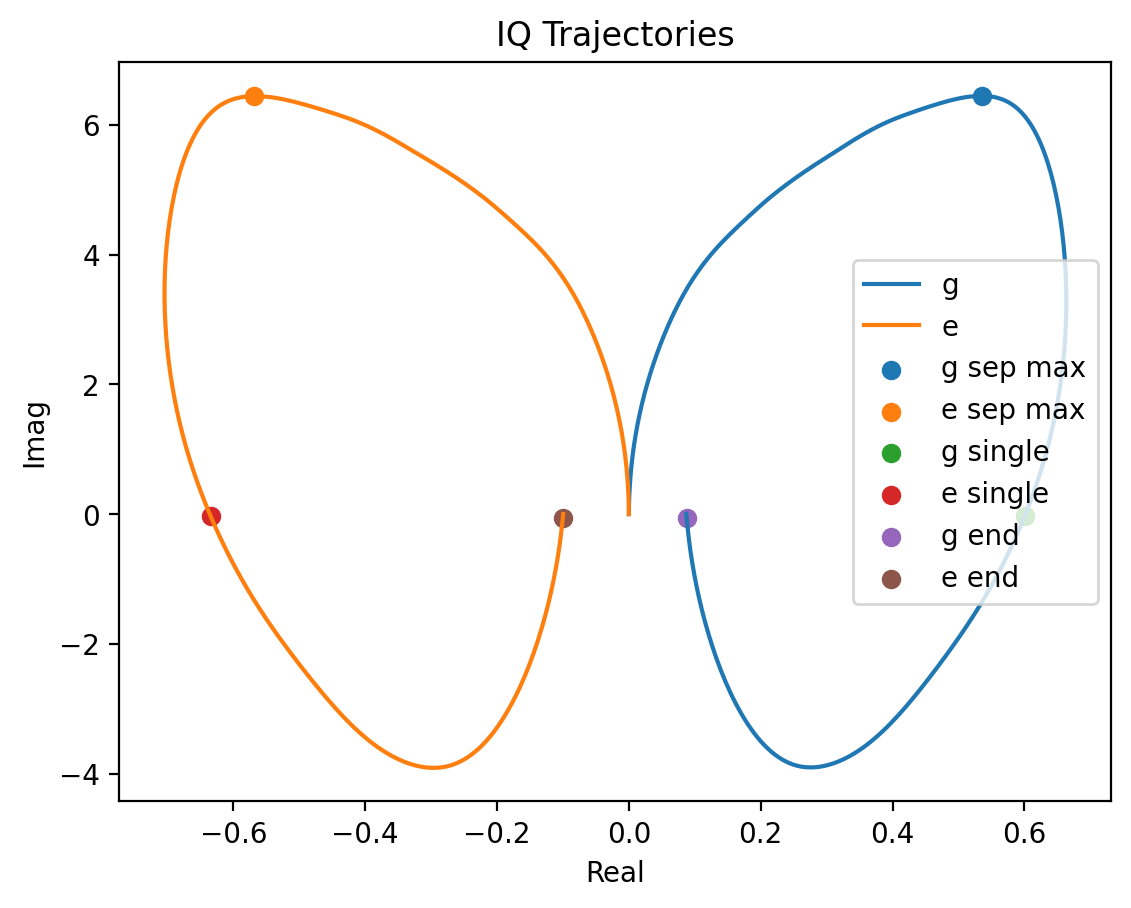

In [87]:
plt.plot(g_real, g_imag, label='g')
plt.plot(e_real, e_imag, label='e')
plt.scatter(g_real[argmax], g_imag[argmax], label='g sep max')
plt.scatter(e_real[argmax], e_imag[argmax], label='e sep max')
plt.scatter(g_real[argmin_2], g_imag[argmin_2], label='g single')
plt.scatter(e_real[argmin_2], e_imag[argmin_2], label='e single')
plt.scatter(g_real[argmin], g_imag[argmin], label='g end')
plt.scatter(e_real[argmin], e_imag[argmin], label='e end')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('IQ Trajectories')
plt.legend()
plt.show()

In [71]:
print(state)

EvoState(mean=Array([ 2.32558140e+00,  2.32558140e+00,  2.32558140e+00,  2.25149682e+00,
        2.32558140e+00,  2.32558140e+00,  2.32558140e+00,  2.32558140e+00,
        2.31287468e+00,  2.22624002e+00,  2.19207283e+00,  2.10589784e+00,
        1.80551602e+00,  2.16720810e+00,  1.43077114e+00,  2.21388228e+00,
        1.40567546e+00,  1.77618038e+00,  1.67017040e+00,  1.59800652e+00,
        1.44618732e+00,  1.55704091e+00,  1.49083511e+00,  1.61592882e+00,
        1.50043485e+00,  1.47971649e+00,  1.81061263e+00,  1.38065977e+00,
        1.68137405e+00,  1.22037217e+00,  1.57756372e+00,  1.04402727e+00,
        1.62107773e+00,  4.29147423e-01,  1.64669429e+00,  3.45823684e-01,
        9.26447931e-01, -6.21676756e-02, -2.63119579e-01, -9.54052722e-01,
       -1.54474882e+00, -1.60006065e+00, -2.28635972e+00, -2.32558140e+00,
       -2.32558140e+00, -2.31147473e+00, -2.28258086e+00, -2.32558140e+00,
       -2.23205873e+00, -2.32558140e+00, -2.28552507e+00, -2.24870318e+00,
       -2.3

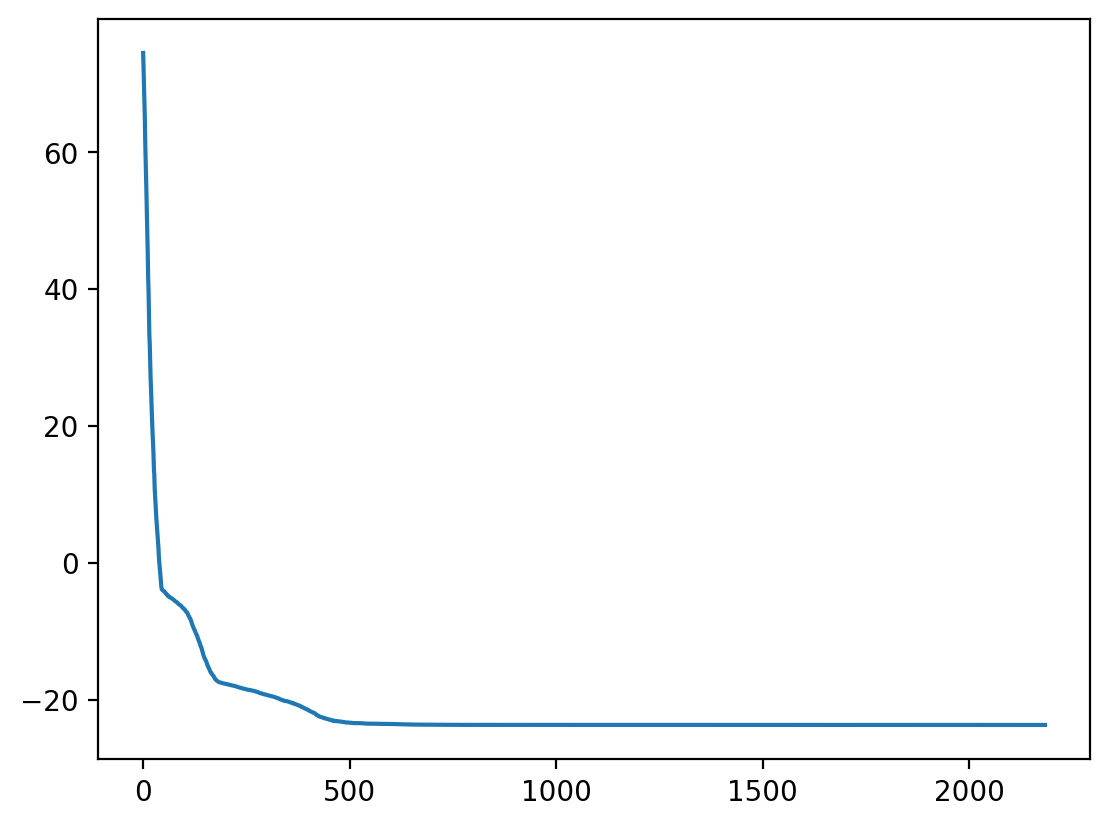

In [88]:
plt.plot(fitness_list)